In [109]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [110]:
Img_size=256
Batch_size=32
CHANNELS=3
Epochs=50

In [111]:
#Creating tensorflow input pipeline
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", #directory with all classes and images
    shuffle=True,
    image_size=(Img_size,Img_size),
    batch_size=Batch_size,

)

Found 2152 files belonging to 3 classes.


In [112]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [113]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 1 0 0 1 1 0 1 2 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0]


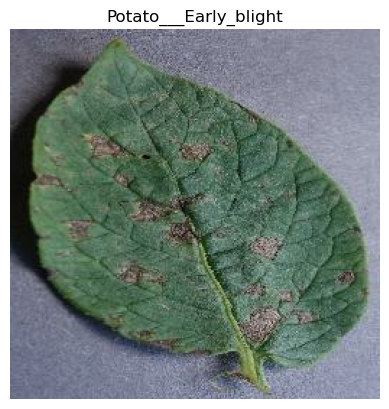

In [114]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")


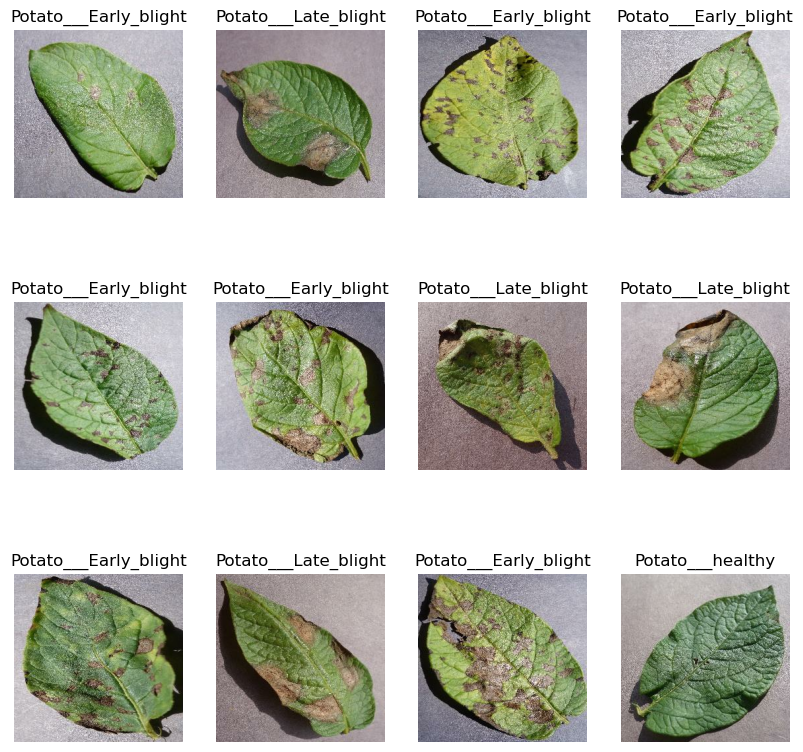

In [115]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        


In [116]:
len(dataset)

68

In [117]:
#Total len(dataset)=68 i.e 68 batchs out of that 80% for training
train_size=0.8
t_size=int(len(dataset)*train_size)
t_size

54

In [118]:
train_ds=dataset.take(t_size)
len(train_ds)

54

In [119]:
#Now remaining will be split  between validation and test 10% each
remaining_ds=dataset.skip(54)
len(remaining_ds)

14

In [120]:
val_size=0.1
v_size=int(len(dataset)*val_size)
v_size

6

In [121]:
val_ds=remaining_ds.take(v_size)
len(val_ds)

6

In [122]:
#Now leftout for test
test_ds=remaining_ds.skip(v_size)
len(test_ds)

8

In [123]:
#Above code into a function
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [124]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [125]:
len(train_ds)


54

In [126]:
len(test_ds)

8

In [127]:
#cache:Store next image in memory,no need to load image again and again for every epoch
#prefetch: lets cpu load the data simultaniously as gpu is training
#both of these make the process fast
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [128]:
#Preprocessing pipeline 
#Rescaling images
resize_rescale=tf.keras.Sequential([
    layers.Resizing(Img_size, Img_size),
    layers.Rescaling(1./255),

])

In [129]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  
])

In [130]:
#CNN model
input_shape = (Batch_size, Img_size, Img_size, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [131]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)



In [133]:
history = model.fit(
    train_ds,
    batch_size=Batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 738ms/step - accuracy: 0.5068 - loss: 0.9353 - val_accuracy: 0.6719 - val_loss: 0.7115
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 721ms/step - accuracy: 0.7289 - loss: 0.6464 - val_accuracy: 0.8281 - val_loss: 0.3786
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 883ms/step - accuracy: 0.8422 - loss: 0.3979 - val_accuracy: 0.8750 - val_loss: 0.2769
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 895ms/step - accuracy: 0.8896 - loss: 0.2887 - val_accuracy: 0.9167 - val_loss: 0.1781
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 822ms/step - accuracy: 0.9118 - loss: 0.2205 - val_accuracy: 0.9583 - val_loss: 0.1514
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 820ms/step - accuracy: 0.9132 - loss: 0.2344 - val_accuracy: 0.8594 - val_loss: 0.3303
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 776ms/step - accuracy: 0.9290 - loss: 0.1862 - val_accuracy: 0.9479 - val_loss: 0.1321
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 789ms/step - accuracy: 0.9298 - loss: 0.1652 - val_accu

In [134]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.9374 - loss: 0.1276


In [135]:
scores

[0.12499464303255081, 0.94140625]

In [136]:
history.params


{'verbose': 1, 'epochs': 10, 'steps': 54}

In [137]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [138]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Accuracy')

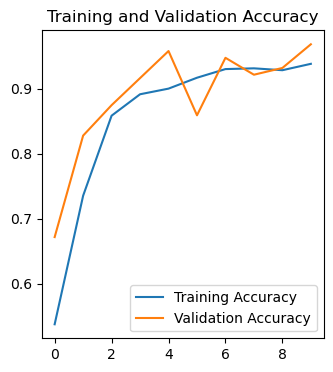

In [140]:
EPOCHS=10
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

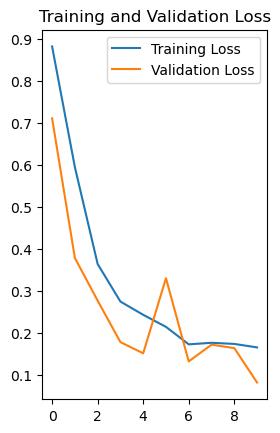

In [141]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
predicted label: Potato___Early_blight


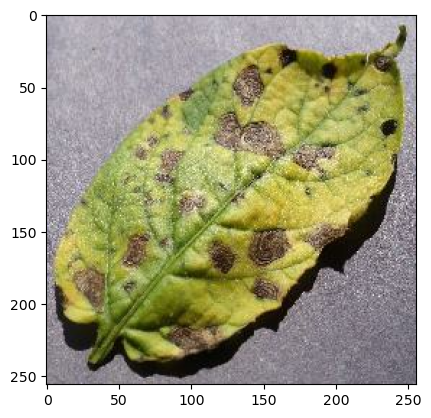

In [142]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [143]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


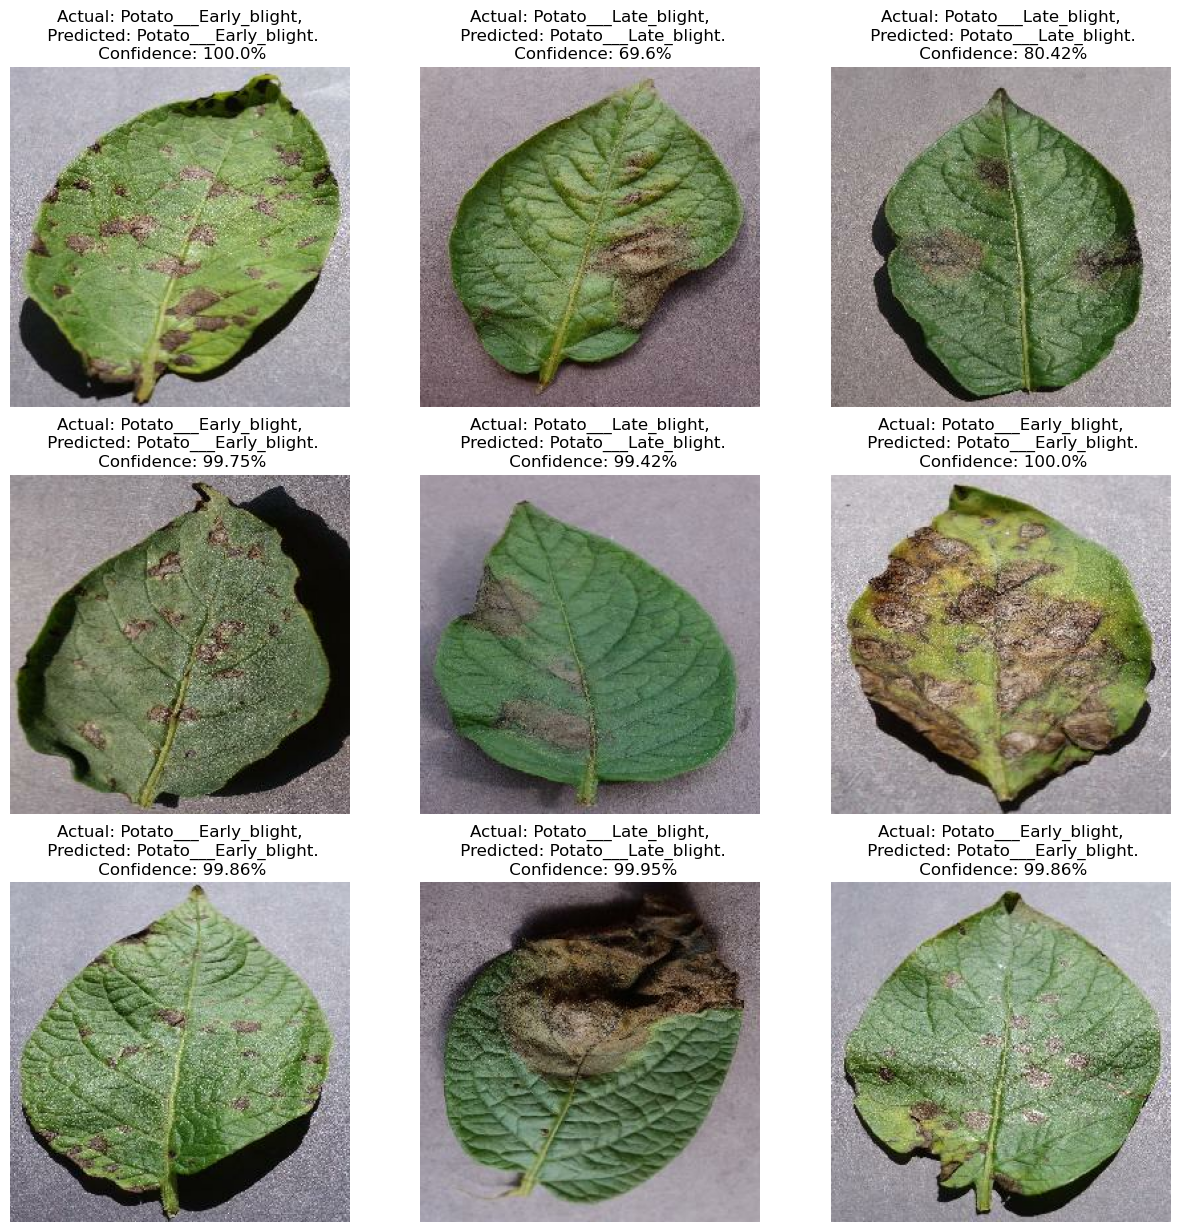

In [144]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [155]:
import os
model_version = 1
model.export(f"models/{model_version}")  # No extension needed for TensorFlow SavedModel format


INFO:tensorflow:Assets written to: models/1/assets


INFO:tensorflow:Assets written to: models/1/assets


Saved artifact at 'models/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_48')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  13444811280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13444813008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13444813584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13444810512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13444811664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13444813392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13444811088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15386674384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15386674576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15386675728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15386675536: TensorSpec(shape=(), dtype=tf.resource, name=N

In [157]:
#Automatically increment the model number.
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.export(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2/assets


INFO:tensorflow:Assets written to: models/2/assets


Saved artifact at 'models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_48')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  13444811280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13444813008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13444813584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13444810512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13444811664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13444813392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13444811088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15386674384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15386674576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15386675728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15386675536: TensorSpec(shape=(), dtype=tf.resource, name=N